# Library

In [1]:
#===========================================================
# Library
#===========================================================
import os
import gc
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from contextlib import contextmanager
import time

import numpy as np
import pandas as pd
import scipy as sp
import random

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import preprocessing
import category_encoders as ce
from sklearn.metrics import mean_squared_error

import torch

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Utils

In [2]:
#===========================================================
# Utils
#===========================================================
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    
def load_df(path, df_name, debug=False):
    if path.split('.')[-1]=='csv':
        df = pd.read_csv(path)
        if debug:
            df = pd.read_csv(path, nrows=1000)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    if logger==None:
        print(f"{df_name} shape / {df.shape} ")
    else:
        logger.info(f"{df_name} shape / {df.shape} ")
    return df

# Config

In [3]:
#===========================================================
# Config
#===========================================================
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 5

# Data Loading

In [4]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            .dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})
svd = pd.read_csv(base_path+'image_svd_features.csv', dtype={'Id':str})

In [5]:
train.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485


In [6]:
reveal_ID.head()

,Id
0,10012
1,10014
2,10020
3,10034
4,10059


In [7]:
ICN_numbers.head()

,ICN_number
0,69
1,53
2,98
3,99
4,45


In [8]:
loading.head()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316


In [9]:
fnc.head()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10003,0.343415,0.109974,0.741641,0.578558,-0.676446,-0.436960,-0.295663,-0.377790,-0.344963,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
3,10004,0.132793,0.258255,0.490769,0.342717,0.091112,0.107969,0.029220,-0.026237,0.094742,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
4,10005,0.291921,0.251254,0.416470,0.511719,-0.362626,-0.164710,-0.289059,-0.015537,-0.087316,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898


In [10]:
sample_submission.head()

,Id,Predicted
0,10003_age,50.0
1,10003_domain1_var1,50.0
2,10003_domain1_var2,50.0
3,10003_domain2_var1,50.0
4,10003_domain2_var2,50.0


In [11]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


# FE

In [12]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')
train = train.merge(svd, on=ID, how='left')
train.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,IC50_sv_2,IC51_sv_0,IC51_sv_1,IC51_sv_2,IC52_sv_0,IC52_sv_1,IC52_sv_2,IC53_sv_0,IC53_sv_1,IC53_sv_2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,-17.799738,166.031494,7.140522,-1.852221,162.160387,-7.110113,-13.135310,174.460828,-42.337720,-12.991372
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,0.709199,163.013239,17.676404,5.821980,143.393550,-2.938574,-11.616378,160.541908,-4.967370,12.948171
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-9.008883,192.778342,-3.093821,-3.798846,175.548164,28.353885,2.312814,179.837870,26.207981,-35.805791
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,5.134978,180.179770,15.868681,4.476608,159.916263,1.243108,-1.608821,179.713214,-30.641977,-4.577734
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485,0.007745,0.009748,0.009356,-0.004219,...,8.405299,159.671422,-3.572671,9.738247,161.434889,2.727811,-2.228822,182.490980,-34.469517,-0.542716


In [13]:
train_features = train.drop(['Id','age','domain1_var1','domain1_var2','domain2_var1','domain2_var2'], axis=1)

In [14]:
# merge
test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')
test = test.merge(svd, on=ID, how='left')
test.head()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC50_sv_2,IC51_sv_0,IC51_sv_1,IC51_sv_2,IC52_sv_0,IC52_sv_1,IC52_sv_2,IC53_sv_0,IC53_sv_1,IC53_sv_2
0,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,13.199830,174.917594,19.152848,-9.928726,169.786225,22.718672,0.167235,164.056775,4.091340,2.155737
1,10006,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,...,31.788352,149.021337,12.370486,37.468679,142.848266,29.108289,12.186597,150.882015,-0.153927,13.956243
2,10010,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,...,-7.542619,190.829387,63.303951,-10.683903,177.471958,-3.953985,7.453443,174.139657,5.815356,13.795921
3,10011,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,...,4.402735,176.593110,16.814323,13.351205,167.346241,-15.989412,-2.907931,75.024373,-11.437069,0.285884
4,10012,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,...,27.425245,168.975699,-2.519493,4.657842,164.809378,3.752162,8.451581,180.592886,-33.029151,8.440923


In [15]:
test_features = test.drop(['Id'], axis=1)

In [16]:
train_features_np = train_features.values
test_features_np = test_features.values

In [81]:
from scipy.spatial import procrustes

In [82]:
procrustes(train_features_np, test_features_np)

ValueError: Input matrices must be of same shape

# Prepare folds

In [16]:
folds = train[[ID]+TARGET_COLS].copy()
Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET_COLS])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,fold
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,2
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,3
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,3
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421,4
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485,4


# MODEL

In [17]:
#===========================================================
# model
#===========================================================
def run_single_lightgbm(param, train_df, test_df, folds, features, target, fold_num=0, categorical=[]):
    
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                               label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx])
    else:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical)

    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))

    num_round = 10000

    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds=100)

    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_num

    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(fold_num, np.sqrt(mean_squared_error(target[val_idx], oof[val_idx]))))
    
    return oof, predictions, fold_importance_df


def run_kfold_lightgbm(param, train, test, folds, features, target, n_fold=5, categorical=[]):
    
    logger.info(f"================================= {n_fold}fold lightgbm =================================")
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df = run_single_lightgbm(param,
                                                                     train,
                                                                     test,
                                                                     folds,
                                                                     features,
                                                                     target,
                                                                     fold_num=fold_,
                                                                     categorical=categorical)
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(np.sqrt(mean_squared_error(target, oof))))

    logger.info(f"=========================================================================================")
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')

### LGB for age ###
================================= 5fold lightgbm =================================
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.34648	valid_1's rmse: 9.74318
[200]	training's rmse: 5.04386	valid_1's rmse: 9.49431
[300]	training's rmse: 3.58289	valid_1's rmse: 9.43487
[400]	training's rmse: 2.61349	valid_1's rmse: 9.40692
[500]	training's rmse: 1.93179	valid_1's rmse: 9.39094
[600]	training's rmse: 1.43731	valid_1's rmse: 9.38574
[700]	training's rmse: 1.0772	valid_1's rmse: 9.38519
[800]	training's rmse: 0.808419	valid_1's rmse: 9.38138
[900]	training's rmse: 0.610633	valid_1's rmse: 9.38027
Early stopping, best iteration is:
[822]	training's rmse: 0.759882	valid_1's rmse: 9.37938


fold0 RMSE score: 9.37938 
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.34005	valid_1's rmse: 9.89701
[200]	training's rmse: 5.03558	valid_1's rmse: 9.65763
[300]	training's rmse: 3.59183	valid_1's rmse: 9.60578
[400]	training's rmse: 2.61976	valid_1's rmse: 9.58038
[500]	training's rmse: 1.93558	valid_1's rmse: 9.56676
[600]	training's rmse: 1.44651	valid_1's rmse: 9.5554
[700]	training's rmse: 1.09028	valid_1's rmse: 9.55404
[800]	training's rmse: 0.823433	valid_1's rmse: 9.54697
[900]	training's rmse: 0.623709	valid_1's rmse: 9.54387
[1000]	training's rmse: 0.474878	valid_1's rmse: 9.53983
[1100]	training's rmse: 0.361324	valid_1's rmse: 9.53802
[1200]	training's rmse: 0.275107	valid_1's rmse: 9.53716
Early stopping, best iteration is:
[1149]	training's rmse: 0.316416	valid_1's rmse: 9.53643


fold1 RMSE score: 9.53643 
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.21194	valid_1's rmse: 10.6984
[200]	training's rmse: 4.96592	valid_1's rmse: 10.3868
[300]	training's rmse: 3.53754	valid_1's rmse: 10.3046
[400]	training's rmse: 2.56902	valid_1's rmse: 10.2884
[500]	training's rmse: 1.89699	valid_1's rmse: 10.2859
[600]	training's rmse: 1.41497	valid_1's rmse: 10.2732
[700]	training's rmse: 1.06425	valid_1's rmse: 10.2718
[800]	training's rmse: 0.805862	valid_1's rmse: 10.2663
[900]	training's rmse: 0.610573	valid_1's rmse: 10.2617
[1000]	training's rmse: 0.461619	valid_1's rmse: 10.2611
[1100]	training's rmse: 0.350158	valid_1's rmse: 10.261
Early stopping, best iteration is:
[1042]	training's rmse: 0.409877	valid_1's rmse: 10.2599


fold2 RMSE score: 10.25990
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.25846	valid_1's rmse: 10.3224
[200]	training's rmse: 4.98862	valid_1's rmse: 10.066
[300]	training's rmse: 3.55914	valid_1's rmse: 9.98993
[400]	training's rmse: 2.59192	valid_1's rmse: 9.96638
[500]	training's rmse: 1.91885	valid_1's rmse: 9.95445
[600]	training's rmse: 1.43525	valid_1's rmse: 9.93387
[700]	training's rmse: 1.07951	valid_1's rmse: 9.93196
[800]	training's rmse: 0.815801	valid_1's rmse: 9.93408
Early stopping, best iteration is:
[724]	training's rmse: 1.00986	valid_1's rmse: 9.93053


fold3 RMSE score: 9.93053 
len(trn_idx) : 4348
len(val_idx) : 1086


Fold 4
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.3011	valid_1's rmse: 10.1202
[200]	training's rmse: 5.01614	valid_1's rmse: 9.89656
[300]	training's rmse: 3.56658	valid_1's rmse: 9.83963
[400]	training's rmse: 2.60239	valid_1's rmse: 9.83444
[500]	training's rmse: 1.92027	valid_1's rmse: 9.83624


fold4 RMSE score: 9.83030 


Early stopping, best iteration is:
[427]	training's rmse: 2.39749	valid_1's rmse: 9.8303


CV RMSE score: 9.79215 
### LGB for domain1_var1 ###
================================= 5fold lightgbm =================================
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.97193	valid_1's rmse: 9.75
[200]	training's rmse: 5.02673	valid_1's rmse: 9.75818


fold0 RMSE score: 9.74200 
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[113]	training's rmse: 6.67235	valid_1's rmse: 9.742
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.99428	valid_1's rmse: 9.58205
[200]	training's rmse: 5.02345	valid_1's rmse: 9.59687


fold1 RMSE score: 9.57694 
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[107]	training's rmse: 6.82591	valid_1's rmse: 9.57694
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.98213	valid_1's rmse: 9.65881
[200]	training's rmse: 5.04504	valid_1's rmse: 9.63919


fold2 RMSE score: 9.63033 
len(trn_idx) : 4347


Early stopping, best iteration is:
[179]	training's rmse: 5.37893	valid_1's rmse: 9.63033
Fold 3


len(val_idx) : 1087


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.91428	valid_1's rmse: 9.92757
[200]	training's rmse: 4.97673	valid_1's rmse: 9.92412
[300]	training's rmse: 3.6642	valid_1's rmse: 9.92023


fold3 RMSE score: 9.90928 
len(trn_idx) : 4348
len(val_idx) : 1086


Early stopping, best iteration is:
[233]	training's rmse: 4.4921	valid_1's rmse: 9.90928
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 6.91609	valid_1's rmse: 10.0698
[200]	training's rmse: 5.00097	valid_1's rmse: 10.0206
[300]	training's rmse: 3.69541	valid_1's rmse: 9.99637
[400]	training's rmse: 2.76849	valid_1's rmse: 9.97578
[500]	training's rmse: 2.08624	valid_1's rmse: 9.97592


fold4 RMSE score: 9.97283 


Early stopping, best iteration is:
[432]	training's rmse: 2.53224	valid_1's rmse: 9.97283


CV RMSE score: 9.76745 
### LGB for domain1_var2 ###
================================= 5fold lightgbm =================================
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.10755	valid_1's rmse: 11.509


fold0 RMSE score: 11.44643
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[8]	training's rmse: 11.0344	valid_1's rmse: 11.4464
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.10829	valid_1's rmse: 11.4794


fold1 RMSE score: 11.42792
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[28]	training's rmse: 10.301	valid_1's rmse: 11.4279
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.1124	valid_1's rmse: 11.3747


fold2 RMSE score: 11.24980
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[28]	training's rmse: 10.3151	valid_1's rmse: 11.2498
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.03362	valid_1's rmse: 11.5743


fold3 RMSE score: 11.42045
len(trn_idx) : 4348
len(val_idx) : 1086


Early stopping, best iteration is:
[4]	training's rmse: 11.203	valid_1's rmse: 11.4204
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.10556	valid_1's rmse: 11.3923


fold4 RMSE score: 11.34475
CV RMSE score: 11.37811


Early stopping, best iteration is:
[50]	training's rmse: 9.5384	valid_1's rmse: 11.3447


### LGB for domain2_var1 ###
================================= 5fold lightgbm =================================
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.76127	valid_1's rmse: 10.7391


fold0 RMSE score: 10.69713
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[49]	training's rmse: 9.264	valid_1's rmse: 10.6971
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.76044	valid_1's rmse: 10.924


fold1 RMSE score: 10.90684
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[91]	training's rmse: 7.99806	valid_1's rmse: 10.9068
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.73504	valid_1's rmse: 11.0049


fold2 RMSE score: 10.98398
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[64]	training's rmse: 8.7515	valid_1's rmse: 10.984
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.68046	valid_1's rmse: 11.1753


fold3 RMSE score: 11.14880
len(trn_idx) : 4348
len(val_idx) : 1086


Early stopping, best iteration is:
[53]	training's rmse: 9.04181	valid_1's rmse: 11.1488
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.72785	valid_1's rmse: 11.122
[200]	training's rmse: 5.64003	valid_1's rmse: 11.1005


fold4 RMSE score: 11.09093
CV RMSE score: 10.96665


Early stopping, best iteration is:
[177]	training's rmse: 6.05139	valid_1's rmse: 11.0909


### LGB for domain2_var2 ###
================================= 5fold lightgbm =================================
len(trn_idx) : 4347
len(val_idx) : 1087


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.27417	valid_1's rmse: 11.8868


fold0 RMSE score: 11.84395
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[44]	training's rmse: 9.99683	valid_1's rmse: 11.844
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.32998	valid_1's rmse: 11.5399
[200]	training's rmse: 6.07533	valid_1's rmse: 11.614


fold1 RMSE score: 11.53463
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[102]	training's rmse: 8.27332	valid_1's rmse: 11.5346
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.254	valid_1's rmse: 11.8516


fold2 RMSE score: 11.80423
len(trn_idx) : 4347
len(val_idx) : 1087


Early stopping, best iteration is:
[16]	training's rmse: 11.0739	valid_1's rmse: 11.8042
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.28122	valid_1's rmse: 11.8413


fold3 RMSE score: 11.80610
len(trn_idx) : 4348
len(val_idx) : 1086


Early stopping, best iteration is:
[40]	training's rmse: 10.1453	valid_1's rmse: 11.8061
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 8.29685	valid_1's rmse: 11.6689


fold4 RMSE score: 11.62770
CV RMSE score: 11.72396


Early stopping, best iteration is:
[17]	training's rmse: 11.0743	valid_1's rmse: 11.6277


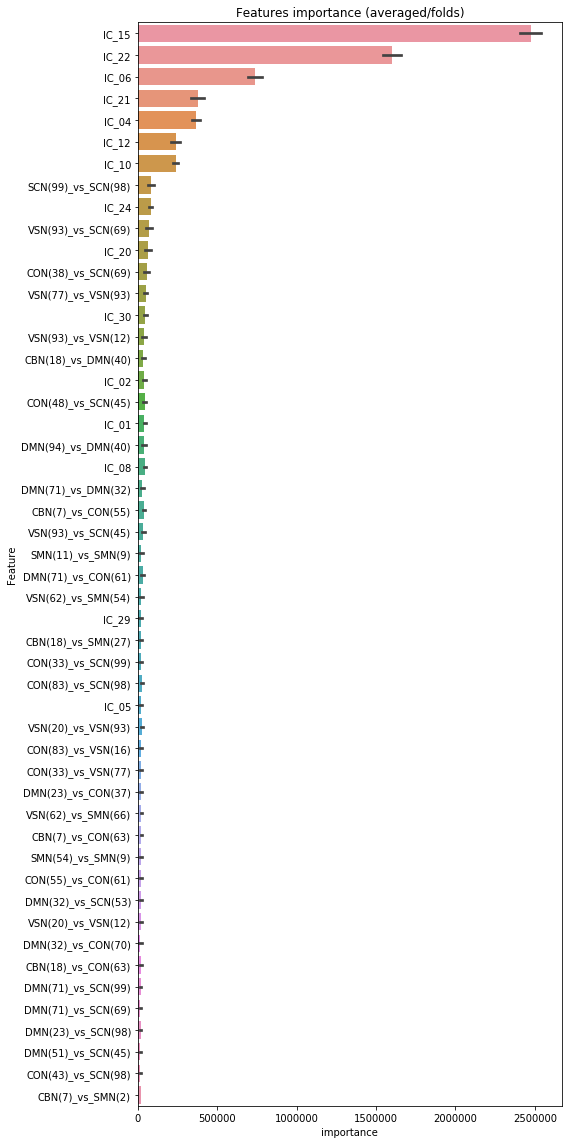

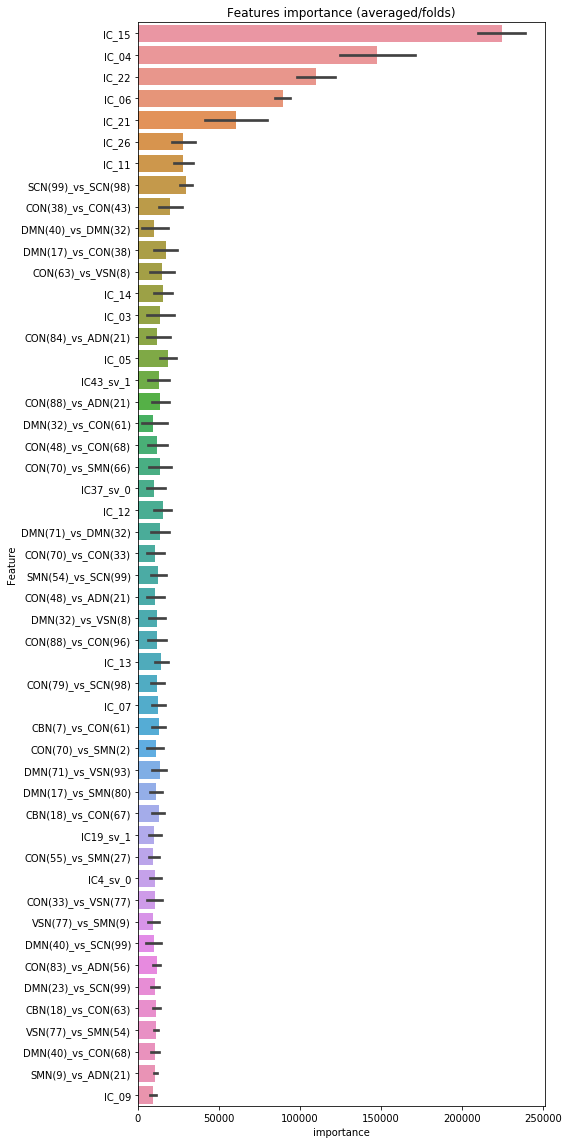

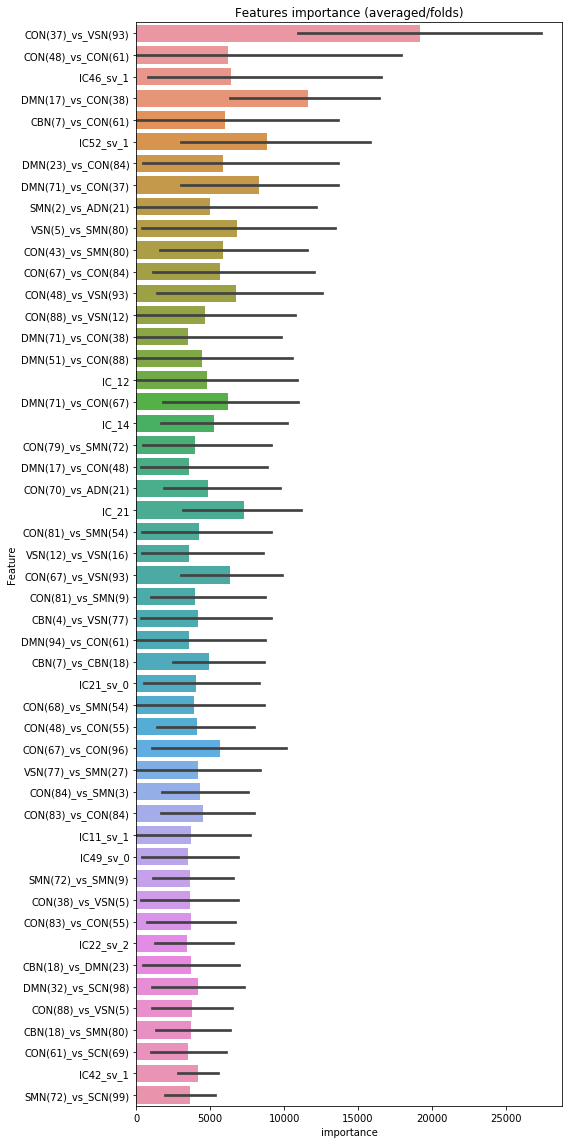

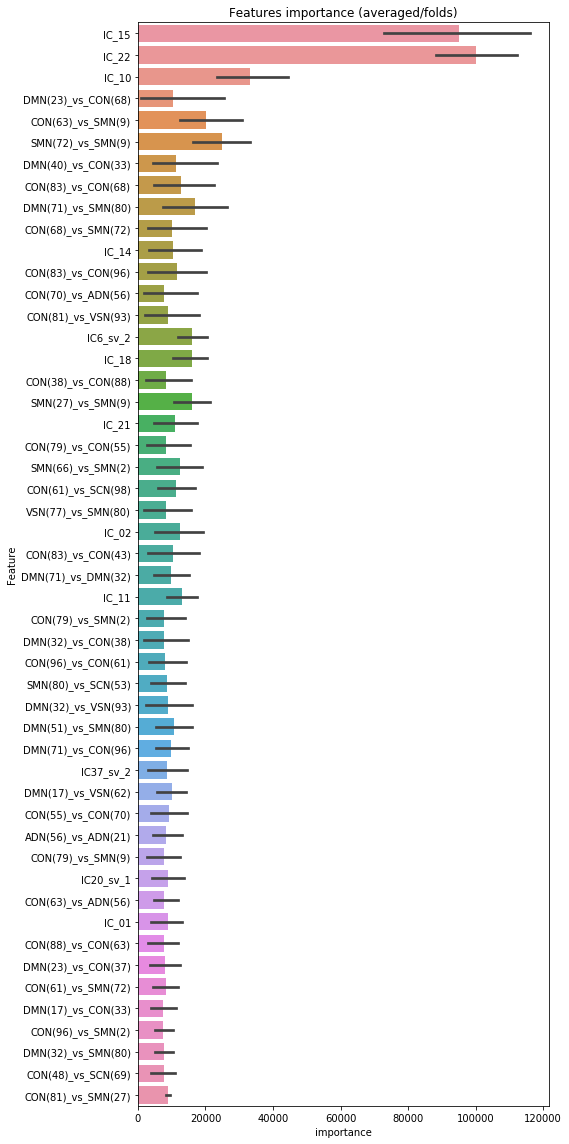

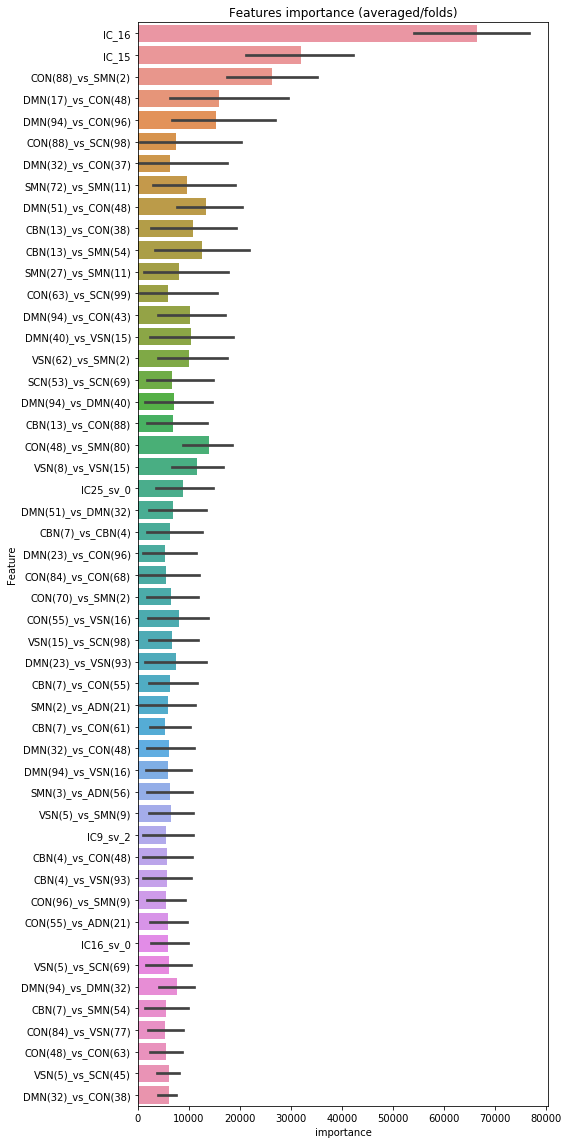

In [18]:
prediction_dict = {}
oof_dict = {}

for TARGET in TARGET_COLS:
    
    logger.info(f'### LGB for {TARGET} ###')

    target = train[TARGET]
    test[TARGET] = np.nan

    # features
    cat_features = []
    num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
    features = num_features + cat_features
    drop_features = [ID] + TARGET_COLS
    features = [c for c in features if c not in drop_features]

    if cat_features:
        ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
        ce_oe.fit(train)
        train = ce_oe.transform(train)
        test = ce_oe.transform(test)
        
    lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.03,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

    feature_importance_df, predictions, oof = run_kfold_lightgbm(lgb_param, train, test, folds, features, target, 
                                                                 n_fold=N_FOLD, categorical=cat_features)
    
    prediction_dict[TARGET] = predictions
    oof_dict[TARGET] = oof
    
    show_feature_importance(feature_importance_df, TARGET)

In [19]:
oof_df = pd.DataFrame()

for TARGET in TARGET_COLS:
    oof_df[TARGET] = oof_dict[TARGET]

In [20]:
# https://www.kaggle.com/akurmukov/trends-starter-rf-0-168-lb-metric

def lb_metric(y_true, y_pred):
    '''Computes lb metric, both y_true and y_pred should be DataFrames of shape n x 5'''
    y_true = y_true[['age', 'domain1_var1', 'domain1_var2','domain2_var1','domain2_var2']]
    y_pred = y_pred[['age', 'domain1_var1', 'domain1_var2','domain2_var1','domain2_var2']]
    weights = np.array([.3, .175, .175, .175, .175])
    return np.sum(weights * np.abs(y_pred.values - y_true.values).sum(axis=0) / y_true.values.sum(axis=0))

In [21]:
score = lb_metric(train, oof_df)
logger.info(f'Local Score: {score}')

Local Score: 0.16310638840093822


# Submission

In [22]:
sample_submission.head()

,Id,Predicted
0,10003_age,50.0
1,10003_domain1_var1,50.0
2,10003_domain1_var2,50.0
3,10003_domain2_var1,50.0
4,10003_domain2_var2,50.0


In [23]:
pred_df = pd.DataFrame()

for TARGET in TARGET_COLS:
    tmp = pd.DataFrame()
    tmp[ID] = [f'{c}_{TARGET}' for c in test[ID].values]
    tmp['Predicted'] = prediction_dict[TARGET]
    pred_df = pd.concat([pred_df, tmp])

print(pred_df.shape)
print(sample_submission.shape)

pred_df.head()

(29385, 2)
(29385, 2)


,Id,Predicted
0,10003_age,49.718728
1,10006_age,57.668842
2,10010_age,40.945921
3,10011_age,46.941959
4,10012_age,56.223087


In [24]:
submission = sample_submission.drop(columns='Predicted').merge(pred_df, on=ID, how='left')
print(submission.shape)
submission.to_csv('submission.csv', index=False)
submission.head()

(29385, 2)


,Id,Predicted
0,10003_age,49.718728
1,10003_domain1_var1,50.292961
2,10003_domain1_var2,59.009396
3,10003_domain2_var1,47.947973
4,10003_domain2_var2,53.619966
